In [44]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [227]:
experiments = ((1,6),(2,3),(3,6))

exp_number = 1
hwm_experiments = experiments[exp_number-1][1]
data = []
for expId, expN in experiments:
    data.append( (expN, np.loadtxt(f'./data/exp{expId}_freefall.csv', delimiter=',', skiprows=1)) )
    

print(data)

[(6, array([[5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.16e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.16e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.34e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.17e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.17e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.17e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.83e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.67e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 4.00e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.66e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0

In [228]:
def error_prop_addition(*args):
    errors = np.array(args)
    return np.sqrt(np.sum(errors**2, axis=0))

def frac_error_prop_mult(*args):
    if type(args[0]) != tuple:
        raise NotImplementedError("Each parameter should be a tuple pair, \
                      where first element is A_err and second element is A")
    args_arr = np.array(args)
    errors = args_arr[:,0]
    abs_values = args_arr[:,1]
    frac_errs = errors/abs_values
    frac_err_propagation = np.sqrt(np.sum(frac_errs**2))
    return frac_err_propagation

def frac_errror_prop_power_single(A_err, A, power):
    return power*A_err/A

def frac_errror_prop_power(*args):
    # @TODO: Figure out how to vectorize this, so that user can simply put in tuples of arrays
    # of A_err, A, and pow, and get back err_propagation. Will leave for the future.
    if type(args[0]) != tuple:
        raise NotImplementedError("Each parameter should be a tuple triplet, \
                      where first element is A_i_err, second element is A_i, \
                      and third elements is n_i, and Z=multOrDiv(A^n)")
    print(*args)
    args_arr = np.array(args)
    print(args_arr)
    errors = args_arr[:,0]
    abs_values = args_arr[:,1]
    exponents = args_arr[:,1]
    frac_errs = errors/abs_values
    
    frac_err_propagation = np.sqrt(np.sum( (frac_errs*exponents)**2))
    return frac_err_propagation
    

In [229]:
def calculate_lsq_g_err(x, y, gradient, model):
    # From Hughes and Hase
    # x should be a simple np array (vector) with N entries, where x_i is a float
    # and it should be the independent variable (e.g. height)
    # y should be a simple np array (vector) with N entries, where y_i is a float
    # and it should be the dependent variable (e.g. time it took to fall, squared)
    x = x.flatten() if (len(x.shape)>1) else x
    y = y.flatten() if (len(y.shape)>1) else y
    N = len(x)
    
    y_pred = model(x, gradient)
    g = 2/gradient
    
    common_uncertainty = np.sqrt((1/(N-2)) * np.sum((y - y_pred)**2)) # magnitude of uncertainty in y-measurements
    Delta = N*np.sum(x**2) - np.sum(x)**2
    gradient_err = common_uncertainty* np.sqrt(N/Delta)
    # since g=2*gradient**(-1), then g_err/g = err_grad/grad
    g_err_frac = gradient_err/gradient
    return g_err_frac

def calculate_lsq_g_err_lookup(m,var_m):
    return 2*(m**(-2)*np.sqrt(var_m)) # not fractional!

def calculate_lsq_g_err_var2er(m, var_m):
    # the standard error of an estimate may be defined as the
    # square root of the estimated error variance of the quantity
    # [Kenney and Keeping 1951, p. 187; Zwillinger 1995, p. 626]
    # https://mathworld.wolfram.com/StandardError.html
    std_err_m = np.sqrt(var_m)
    g_err_frac = std_err_m/m
    return g_err_frac

def least_squares_fitting_predict_g(X,Y,Y_err,model=None):
    fitting_line = lambda x,m: m*x
    model = model if (model is not None) else fitting_line
    params, params_covariance = curve_fit(model, X, Y, sigma=Y_err)
    ## We only have 1 variables in the model, the gradient, so covariance matrix is 1x1
    m = params[0]
    m_var = params_covariance[0][0]
    
    g = 2/m
    #g_err = g*calculate_lsq_g_err(X,Y,m,model)
    #g_err = calculate_lsq_g_err_lookup(m,m_var)
    g_err = g*calculate_lsq_g_err_var2er(m,m_var)
    
    return ((g, g_err), (params, params_covariance), model)

The least squares fitting method for exp 1 predicted g = 9.703 ± 0.043 ms^-2.
The least squares fitting method for exp 2 predicted g = 10.283 ± 0.102 ms^-2.
The least squares fitting method for exp 3 predicted g = 9.784 ± 0.086 ms^-2.


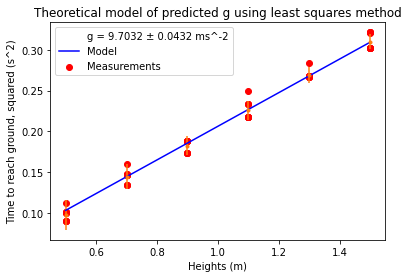

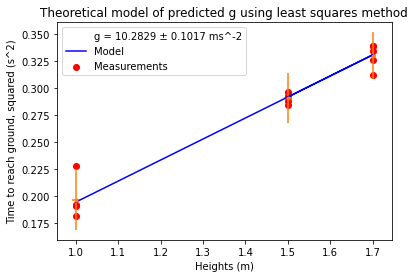

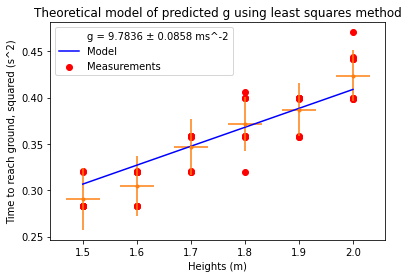

In [232]:
heights_per_exp_all = []
tf_sq_per_exp_all = []

tf_sq_all_exp = []
heights_all_exp = []

theoretical_model_individuals = []

for exp_number, experiment in enumerate(data):
    hwm_experiments = experiment[0]
    experiment_data = experiment[1]
    # Arrays containing t^2 and h for this experiment (combined heights)
    tf = experiment_data[:,4]-experiment_data[:,2]
    tf_err = error_prop_addition(experiment_data[:,5],experiment_data[:,3])
    tf_sq = tf**2
    #tf_sq_err = tf_sq*frac_errror_prop_power( (tf_err,tf,2) )
    tf_sq_err = frac_errror_prop_power_single(tf_err, tf, 2)
    heights = experiment_data[:,0]
    heights_err= experiment_data[:,1]
    
    tf_sq_all_exp.append(np.stack((tf_sq, tf_sq_err)))
    heights_all_exp.append(np.stack((heights, heights_err)))
    
    gs, params_and_cov, model = least_squares_fitting_predict_g(heights, tf_sq, tf_sq_err)
    theoretical_model_individuals.append( (gs, params_and_cov, model) )
    print(f"The least squares fitting method for exp {exp_number+1} predicted g = {gs[0]:.3f} ± {gs[1]:.3f} ms^-2.")
    
    # Arrays containing t^2 and h for this experiment (segregated by heights)
    heights_per_exp = np.array(np.split(heights,hwm_experiments))
    heights_err_per_exp = np.array(np.split(heights_err, hwm_experiments))
    tf_sq_per_exp = np.array(np.split(tf_sq,hwm_experiments))
    tf_sq_err_per_exp = np.array(np.split(tf_sq_err,hwm_experiments))

    heights_avg_per_exp = np.average(heights_per_exp, axis=1)
    heights_std_err_per_exp = 1/np.sqrt(np.sum((1/heights_err_per_exp)**2, axis=1))## Hughes and Hase,
    tf_sq_avg_per_exp = np.average(tf_sq_per_exp, axis=1)
    #tf_sq_std_err_per_exp = np.sqrt(np.sum(tf_sq_err_per_exp**2, axis=1))
    tf_sq_std_err_per_exp = 1/np.sqrt(np.sum((1/tf_sq_err_per_exp)**2, axis=1)) ## Hughes and Hase,
    
    tf_sq_per_exp_all.append(np.stack((tf_sq_avg_per_exp, tf_sq_std_err_per_exp)))
    heights_per_exp_all.append(np.stack((heights_avg_per_exp, heights_std_err_per_exp)))
    
experiments_compendium = zip(heights_per_exp_all, tf_sq_per_exp_all, \
                             tf_sq_all_exp, heights_all_exp, theoretical_model_individuals)
exp_n = 1
for hpexp, tfsqpex, tfsqAll, hsAll, th in experiments_compendium:
    heights = hsAll[0]
    heights_errs = hsAll[1]
    tf_sq = tfsqAll[0]
    tf_sq_errs = tfsqAll[1]
    
    heights_avg = hpexp[0]
    heights_std_err = hpexp[1]
    tf_sq_avg = tfsqpex[0]
    tf_sq_std_err = tfsqpex[1]
    
    gs= th[0]
    params_and_cov = th[1]
    model = th[2]
    
    theoretical_prediction = model(heights, params_and_cov[0][0])

    plt.figure()
    plt.plot([],[], ' ', label=f"g = {gs[0]:.4f} ± {gs[1]:.4f} ms^-2")
    plt.scatter(heights, tf_sq, color='r', label='Measurements')
    plt.plot(heights, theoretical_prediction, color='b',label='Model')

    plt.xlabel("Heights (m)")
    plt.ylabel("Time to reach ground, squared (s^2)")
    plt.title("Theoretical model of predicted g using least squares method")
    plt.legend()
    plt.errorbar(heights_avg, tf_sq_avg, tf_sq_std_err, heights_std_err , fmt='.')
    plt.savefig(f'./plots/model_exp{exp_n}.png',dpi=(125))
    plt.show()
    exp_n= exp_n+1
    



[[0.0972735  0.1445002  0.1823125  0.2256535  0.2685558  0.3099823
  0.290535   0.3300108  0.1967324  0.2903773  0.3048577  0.3468019
  0.3714877  0.3868714  0.4235421 ]
 [0.01825052 0.01497402 0.01184982 0.01198261 0.00976344 0.00908765
  0.02305284 0.02163015 0.02801468 0.0331966  0.03239861 0.03037626
  0.02934964 0.02876019 0.02748696]]


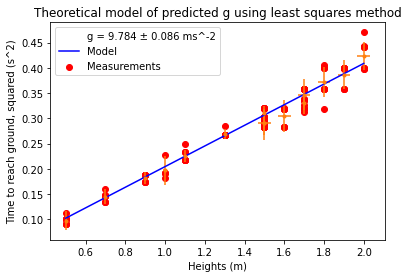

In [234]:
tf_sq_all_combined_exps = np.concatenate(tf_sq_all_exp, axis=1)
heights_all_combined_exps = np.concatenate(heights_all_exp, axis=1)

tf_sq_all_combined_exps_per_height = np.concatenate(tf_sq_per_exp_all, axis=1)
heights_all_combined_exps_per_height = np.concatenate(heights_per_exp_all, axis=1)

print(tf_sq_all_combined_exps_per_height)

all_heights_combined = heights_all_combined_exps[0]
all_tf_sq_combined = tf_sq_all_combined_exps[0]

all_heights_combined_per_hegight_avg = heights_all_combined_exps_per_height[0]
all_heights_combined_per_hegight_std = heights_all_combined_exps_per_height[1]
all_tf_sq_combined_per_hegight_avg = tf_sq_all_combined_exps_per_height[0]
all_tf_sq_combined_per_hegight_std = tf_sq_all_combined_exps_per_height[1]

theoretical_prediction_general = model(all_heights_combined, params_and_cov[0][0])

plt.figure()
plt.plot([],[], ' ', label=f"g = {gs[0]:.3f} ± {gs[1]:.3f} ms^-2")
plt.scatter(all_heights_combined, all_tf_sq_combined, color='r', label='Measurements')
plt.plot(all_heights_combined, theoretical_prediction_general, color='b',label='Model')

plt.xlabel("Heights (m)")
plt.ylabel("Time to reach ground, squared (s^2)")
plt.title("Theoretical model of predicted g using least squares method")
plt.legend()
plt.errorbar(all_heights_combined_per_hegight_avg, all_tf_sq_combined_per_hegight_avg, \
             all_tf_sq_combined_per_hegight_std, all_heights_combined_per_hegight_std , fmt='.')
plt.savefig(f'./plots/model_exp_general.png',dpi=(125))
plt.show()

In [175]:
N = heights.shape[0]
m = params_and_cov[0][0]
var_m = params_and_cov[1][0,0]
# g = 2/m ==> dg/g = dm/m
std_err_m = np.sqrt(var_m)
g_err_frac = std_err_m/m
g_err = gs[0]*g_err_frac
g_err

2*(m**(-2)*std_err_m)

0.04315990806622393

In [143]:
std_err_m/m

0.004448020475095137

In [144]:
2/m

9.703172075731239

In [145]:
g_err

0.04315990806622393

In [186]:
data[0][1].shape

(60, 6)

In [188]:
np.zeros((1))

array([0.])

In [200]:
tf_sq_all_exp = np.concatenate(tf_sq_all_exp, axis=1)
heights_all_exp = np.concatenate(heights_all_exp, axis=1)

In [204]:
gs, params_and_cov, model = least_squares_fitting_predict_g(heights_all_exp[0], tf_sq_all_exp[0], tf_sq_all_exp[1])


In [219]:

experiments_compendium = zip(heights_per_exp_all, tf_sq_per_exp_all, \
                             tf_sq_all_exp, heights_all_exp, theoretical_model_individuals)
for hpexp, tfsqpex, tfsqAll, hsAll, th in experiments_compendium:
    heights = hsAll[0]
    heights_errs = hsAll[1]
    tf_sq = tfsqAll[0]
    tf_sq_errs = tfsqAll[1]
    
    heights_avg = hpexp[0]
    heights_std_err = hpexp[1]
    tf_sq_avg = tfsqpex[0]
    tf_sq_std_err = tfsqpex[1]
    
    gs= th[0]
    params_and_cov = th[1]
    model = th[2]
    
    print(heights)
    print(heights_avg)
    print(heights_std_err)
    print()
    print(tf_sq)
    print(tf_sq_avg)
    print(tf_sq_std_err)
    print()
    print(gs)
    print(params_and_cov)
    print("BYE")
    
    

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.1 1.1 1.1 1.1 1.1 1.1
 1.1 1.1 1.1 1.1 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5]
[0.5 0.7 0.9 1.1 1.3 1.5]
[0.00015811 0.00015811 0.00015811 0.00015811 0.00015811 0.00015811]

[0.099856 0.099856 0.111556 0.09     0.09     0.100489 0.100489 0.09
 0.09     0.100489 0.146689 0.134689 0.16     0.133956 0.134689 0.146689
 0.146689 0.147456 0.147456 0.146689 0.188356 0.173889 0.188356 0.173889
 0.173889 0.187489 0.188356 0.187489 0.173056 0.188356 0.233289 0.233289
 0.218089 0.218089 0.233289 0.25     0.218089 0.217156 0.218089 0.217156
 0.267289 0.266256 0.266256 0.267289 0.284089 0.267289 0.267289 0.266256
 0.266256 0.267289 0.3025   0.320356 0.321489 0.3025   0.321489 0.3025
 0.3025   0.321489 0.3025   0.3025  ]
[0.0972735 0.1445002 0.1823125 0.2256535 0.2685558 0.3099823]
[0.01825052 0.01497402 0.01184982 0.01198261 0.00976344